# Micro Level Analysis: Focusing on Organizations

In this part of the analysis, we will focus on organizations as the unit of technological capability. 

Let us import all relevant libraries

In [1]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
import operator
from IPython.display import display, HTML
from matplotlib.colors import ListedColormap

# please add your plotly api credentials to plotly_config in your own machine. Visit https://plot.ly/python/getting-started/
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

### Table of Contents:     
- [1.Characterizing organizations](#one)
    - [1.1.Preparations](#one-one)
    - [1.2.Capability Matrix of the Technical University of Dennmark](#one-two)
- [2.Organization correlation matrix and organization profiles](#two)
    - [2.1.Correlation Matrices](#two-one)
    - [2.2.Organization profiles](#two-two)
- [3.Comparing organizations](#three)
    - [3.1.Visual Representation](#three-one)
    - [3.2.Most frequent term pairs](#three-two)
    - [3.3.Top differences](#three-three)
- [4.Collaborations](#four)
    - [4.1.All organizations](#four-one)
    - [4.2.Universities](#four-two)
    - [4.3.Non-Universities](#four-three)
- [5.Organizational spectrums](#five)
    - [5.1.Zoom in version](#five-one)
    - [5.2.Limited Organizations](#five-two)
    - [5.3.Full representation](#five-three)
    - [5.4.DTU neighbours](#five-four)

## 1.Characterizing organizations <a class="anchor" id="one"></a>
### 1.1.Preparations <a class="anchor" id="one-one"></a>

Let us create a list of the danish organization that we want to focus on: 

In [2]:
dk_organizations = ["TECH UNIV DENMARK", 
                   "NOVOZYMES AS", 
                   "AALBORG UNIV", 
                   "UNIV COPENHAGEN", 
                   "AARHUS UNIV", 
                   "UNIV SO DENMARK", 
                   "RISO DTU", 
                   "DONG ENERGY"]

Then we query all of the organziations in the database. 

In [3]:
# query orgs
org_available_q = """       MATCH (n:Asset)
                            WITH n.owner as ORG
                            RETURN ORG, count(ORG)
                            ORDER BY count(ORG) DESC"""

# create a list with the years where records exist
raw_data = DataFrame(connection_to_graph.data(org_available_q)).as_matrix()[:, 0]
organizations = list(raw_data)

# print an example organization
print 'We found {} organizations'.format(len(organizations))

We found 10638 organizations


Let us get the names of all of the terms in the biofuel dictionnary

In [4]:
f_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
o_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:Output) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
pt_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:ProcessingTech) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
bbo = list(set(f_terms + pt_terms + o_terms))
print len(bbo)
matrix_axis_names = bbo

352


In [5]:
def find_index(something, in_list):
    return in_list.index(something)

We create a function that given an organization, returns its capability matrix

In [6]:
def get_org_matrix(org, normalization=True):
    
    # define queries
    org_no_interestions = """   MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                    MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                    MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                    WHERE a.owner CONTAINS "{}"
                                    RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(org)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    org_intersections = """     MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                    WHERE fs<>t AND a.owner CONTAINS "{}"
                                    RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_no_intersections = DataFrame(connection_to_graph.data(org_no_interestions)).as_matrix()
    
    # create matrix
    org_matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])
    
    # for no intersections data
    for row in data_no_intersections:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
        # add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            org_matrix[pair[0], pair[1]] += frequency
            org_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(org_intersections.format(category, category, org))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
            # add frequency value to matrix position
            for pair in itertools.combinations(indexes, 2):
                org_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                org_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    normalized_org_matrix = (org_matrix - np.mean(org_matrix)) / np.std(org_matrix)
    
    # dynamic return 
    if normalization == True:
        return normalized_org_matrix
    else: 
        return org_matrix

Some auxiliary functions to study organizations: 

In [7]:
def check_symmetric(a, tol):
    return np.allclose(a, a.T, atol=tol)

def basic_stats(a_matrix):
    print 'Rows:', a_matrix.shape[0]
    print 'Columns:', a_matrix.shape[1]
    print 'Mean: ', np.mean(a_matrix)
    print 'Standart Deviation', np.std(a_matrix)
    print 'Max: ', np.amax(a_matrix)
    print 'Min: ', np.amin(a_matrix)
    print 'Symmetry: ', check_symmetric(a_matrix, 1e-8)
    print ''

### 1.2.Capability Matrix of the Technical University of Dennmark <a class="anchor" id="one-two"></a>

Let's look at DTU's matrix: 

Rows: 352
Columns: 352
Mean:  -1.4336557652700885e-18
Standart Deviation 1.0000000000000002
Max:  106.09396299796008
Min:  -0.04784284383462308
Symmetry:  True



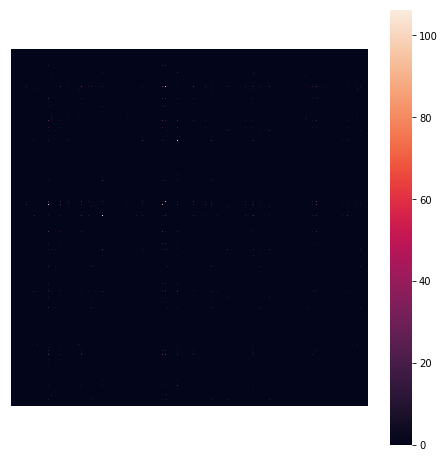

The maximum value of the TECH UNIV DENMARK matrix is in position (90, 164) with value 106.093962998 and concerns  anaerobic digestion and biogas.


In [8]:
univ = 'TECH UNIV DENMARK'
univ_matrix = get_org_matrix(univ, normalization=True)
basic_stats(univ_matrix)


plt.subplots(1,1,figsize=(8, 8))
plt.subplot(111)
sns.heatmap(univ_matrix, cbar=True, square=True, yticklabels=False, xticklabels=False)
plt.show()


i,j = np.unravel_index(univ_matrix.argmax(), univ_matrix.shape)
print 'The maximum value of the {} matrix is in position {} with value {} and concerns {} and {}.'.format(univ, (i, j), univ_matrix[i,j], matrix_axis_names[i], matrix_axis_names[j])

## 2.Organization correlation matrix and organization profiles <a class="anchor" id="two"></a>
### 2.1.Correlation Matrices <a class="anchor" id="two-one"></a>

A function that returns the capability list from the capability matrix

In [9]:
def get_list_from(matrix):
    only_valuable = []
    extension = 1
    for row_number in range(matrix.shape[0]):
        only_valuable.append(matrix[row_number, extension:matrix.shape[0]].tolist()) # numpy functions keep 0s so I hard coded it. 
        extension += 1 
    return [element for column in only_valuable for element in column ]

We now add the list of DK organizations and the organizations with more than 7 assets:

In [10]:
# query orgs
assetLimit = 7
org_available_q = """     MATCH (n:Asset)
                            WITH n.owner as ORG
                            RETURN ORG, count(ORG)
                            ORDER BY count(ORG) DESC"""

# create a list with the years where records exist from 1 to remove null
raw_data = DataFrame(connection_to_graph.data(org_available_q)).as_matrix()[1::] 
list_of_organizations = []
for row in raw_data:
    if row[1] >= assetLimit:
        list_of_organizations.append(row[0])

organizations = list(set(list_of_organizations + dk_organizations))
print 'The list of organizations now has {} organizations.'.format(len(organizations))

The list of organizations now has 115 organizations.


Create a dictionnary of organization capability lists for efficiency. 

In [11]:
# create dictionnary
org_capability_dict = {}
counter = 0

# iterate through countries
for org in organizations:
    
    counter += 1
    org_matrix = get_org_matrix(org.encode('utf-8').strip(), normalization=True)
    
    # discart if no information
    if np.all(np.isnan(org_matrix)):
        continue
        
    else: 
        org_capability_dict[org] = get_list_from(org_matrix)
        
    #print org, sum(get_list_from(org_matrix))

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning:

invalid value encountered in divide



A function that calculates the correlation: 

In [12]:
def calculate_org_correlation(org1_list, org2_list, stat):
    avg_dif = np.mean(org1_list - org2_list)
    abs_avg_dif = abs(avg_dif)
    
    if stat.lower() == 'absolute average difference': # return absolute average difference
        return abs_avg_dif
    if stat == 'Pearson':                             # return Pearson coef
        return stats.pearsonr(org1_list, org2_list)[0]
    if stat == 'P-value':                             # return P-value
        return stats.pearsonr(org1_list, org2_list)[1]

Let's print all the organizations: 

In [13]:
org_names = org_capability_dict.keys()

org_names.sort()
number_of_orgs = len(org_names)
print 'There are {} organizations.'.format(number_of_orgs)
print 'List of Organizations:'
print org_names


There are 112 organizations.
List of Organizations:
['AALBORG UNIV', 'AARHUS UNIV', u'ABELLON CLEANENERGY LTD', u'ABENGOA BIOENERGIA NUEVAS TECNOLOGIAS SA', u'ABENGOA BIOENERGY CORP.', u'AGENCIA ESTATAL CONSEJO SUPERIOR DEINVESTIGACIONES CIENTIFICAS', u'AMYRIS, INC.', u'ARCHER DANIELS MIDLAND', u'ARCHER-DANIELS MIDLAND CO', u'ARGONNE NATL LAB', u'ARISTOTLE UNIV THESSALONIKI', u'ARS', u'BAYER CROPSCIENCE NV', u'BEIJING FORESTRY UNIV', u'BEIJING UNIV CHEM TECHNOL', u'BETA RENEWABLES', u'BUNGE ACUCAR E BIOENERGIA LTDA', u'CHEVRON USA INC;CHEVRON USA INC', u'CHINA AGR UNIV', u'CHINESE ACAD SCI', u'CHINESE ACAD SCI;CHINESE ACAD SCI', u'CHINESE ACAD SCI;UNIV CHINESE ACAD SCI', u'COPERSUCAR S.A.', u'CORNELL UNIV;CORNELL UNIV', u'CSIR', u'CSIR IICT', 'DONG ENERGY', u'E CHINA UNIV SCI & TECHNOL', u'ECOLE POLYTECH FED LAUSANNE', u'EQUOS RES KK', u'FLINT HILLS RESOURCES, LP', u'FOREST CONCEPTS LLC', u'GREEN PLAINS RENEWABLE ENERGY', u'HELIAE DEV LLC', u'INDIAN INST CHEM TECHNOL', u'INDIAN INST TE

And we build the correlation matrix

In [14]:
idxs = [org_names.index(e) for e in dk_organizations]
my_label_colors = {}
for name in org_names:
        if name in dk_organizations:
            my_label_colors[name] = 'r'
        else:
            my_label_colors[name] = 'black'

In [15]:
org_correlation = np.zeros([number_of_orgs, number_of_orgs])
for row in range(number_of_orgs):
    org_1 = org_names[row]
    org_1_list = np.asarray(org_capability_dict[org_1])
    for column in range(number_of_orgs):
        org_2 = org_names[column]
        org_2_list = np.asarray(org_capability_dict[org_2])

        org_correlation[row, column] = calculate_org_correlation(org_1_list, org_2_list, 'Pearson')
        

In [16]:
print len(sorted(org_capability_dict.keys()))

112


In [17]:
print 'Minimum correlation value is {} for organizations {} and {}.'.format(org_correlation[np.unravel_index(org_correlation.argmin(),
                                             org_correlation.shape)[0],
                            np.unravel_index(org_correlation.argmin(), 
                                             org_correlation.shape)[1]],
        org_names[np.unravel_index(org_correlation.argmin(), 
                                       org_correlation.shape)[0]], 
        org_names[np.unravel_index(org_correlation.argmin(), 
                                       org_correlation.shape)[1]])

Minimum correlation value is -0.00220367057387 for organizations ABENGOA BIOENERGIA NUEVAS TECNOLOGIAS SA and FOREST CONCEPTS LLC.


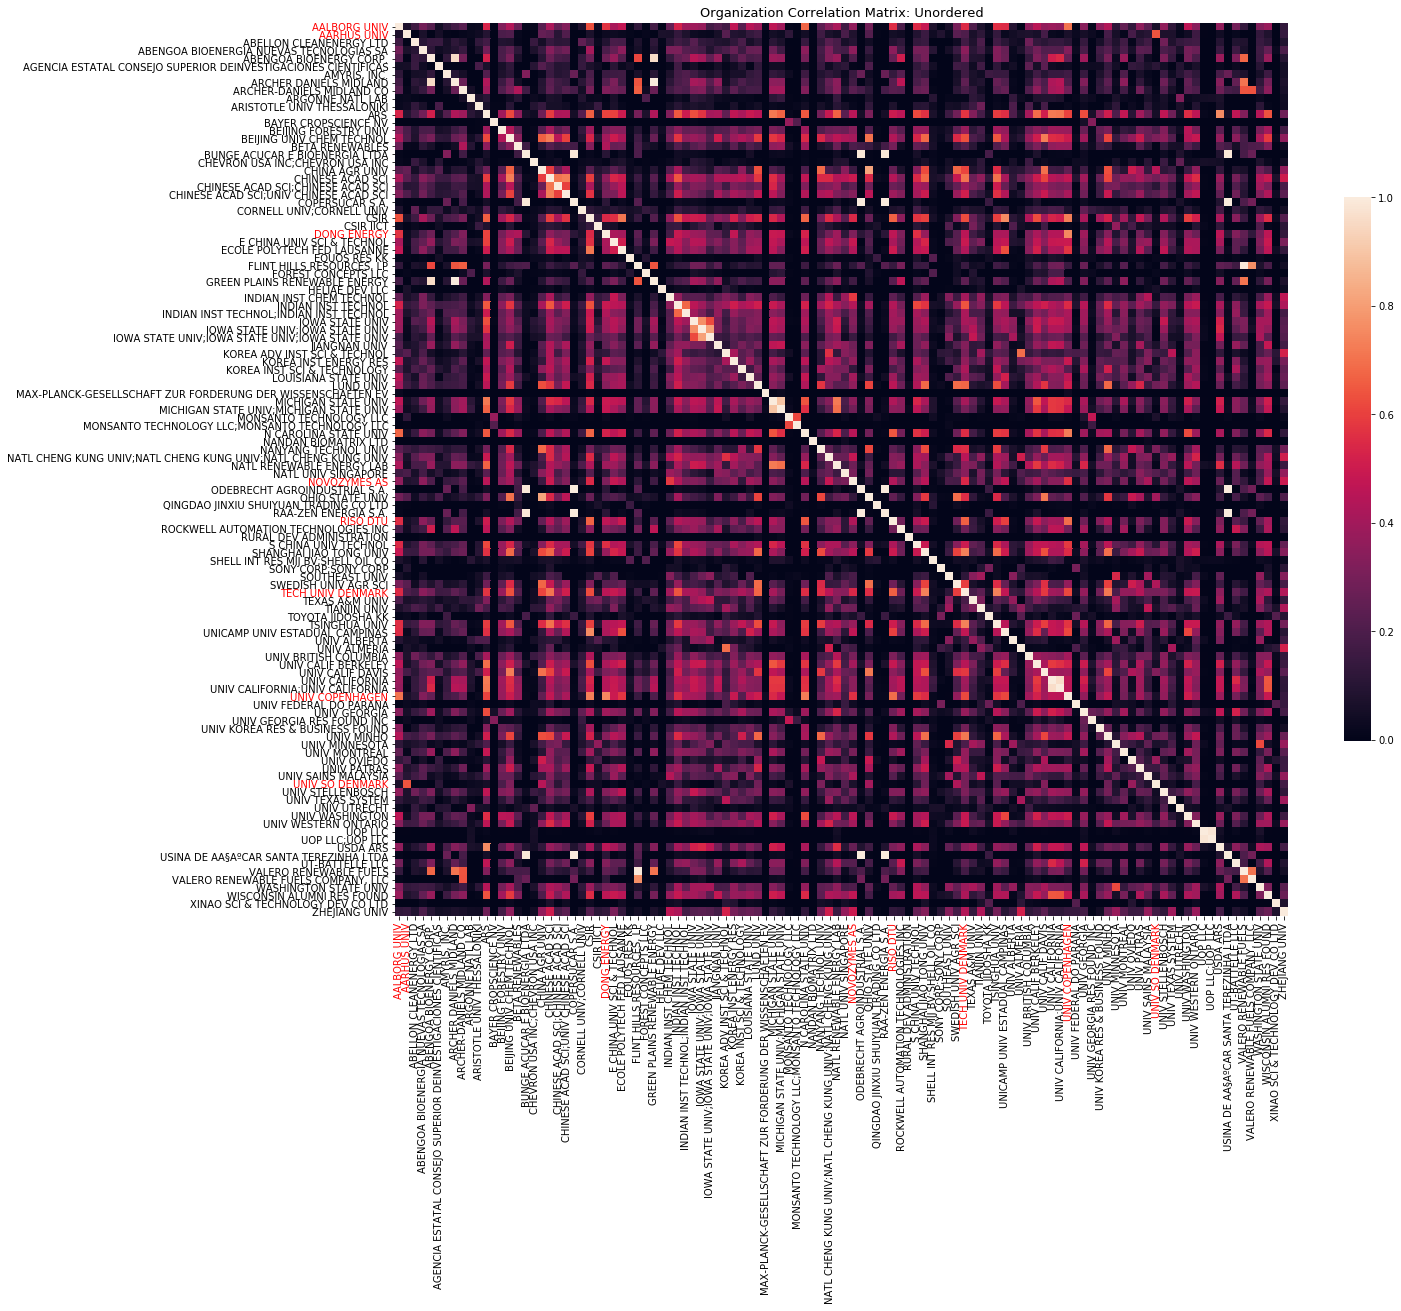

In [18]:
plt.subplots(1,1,figsize=(20, 20))
plt.subplot(111)
sns.heatmap(org_correlation, cbar=True, cbar_kws={"shrink": .5}, square=True, yticklabels=org_names, xticklabels=org_names)
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(my_label_colors[lbl.get_text()])
ylbls = ax.get_ymajorticklabels()
for lbl in ylbls:
    lbl.set_color(my_label_colors[lbl.get_text()])
plt.title('Organization Correlation Matrix: Unordered', size=13)
plt.show()

We apply hierarchical clustering: 

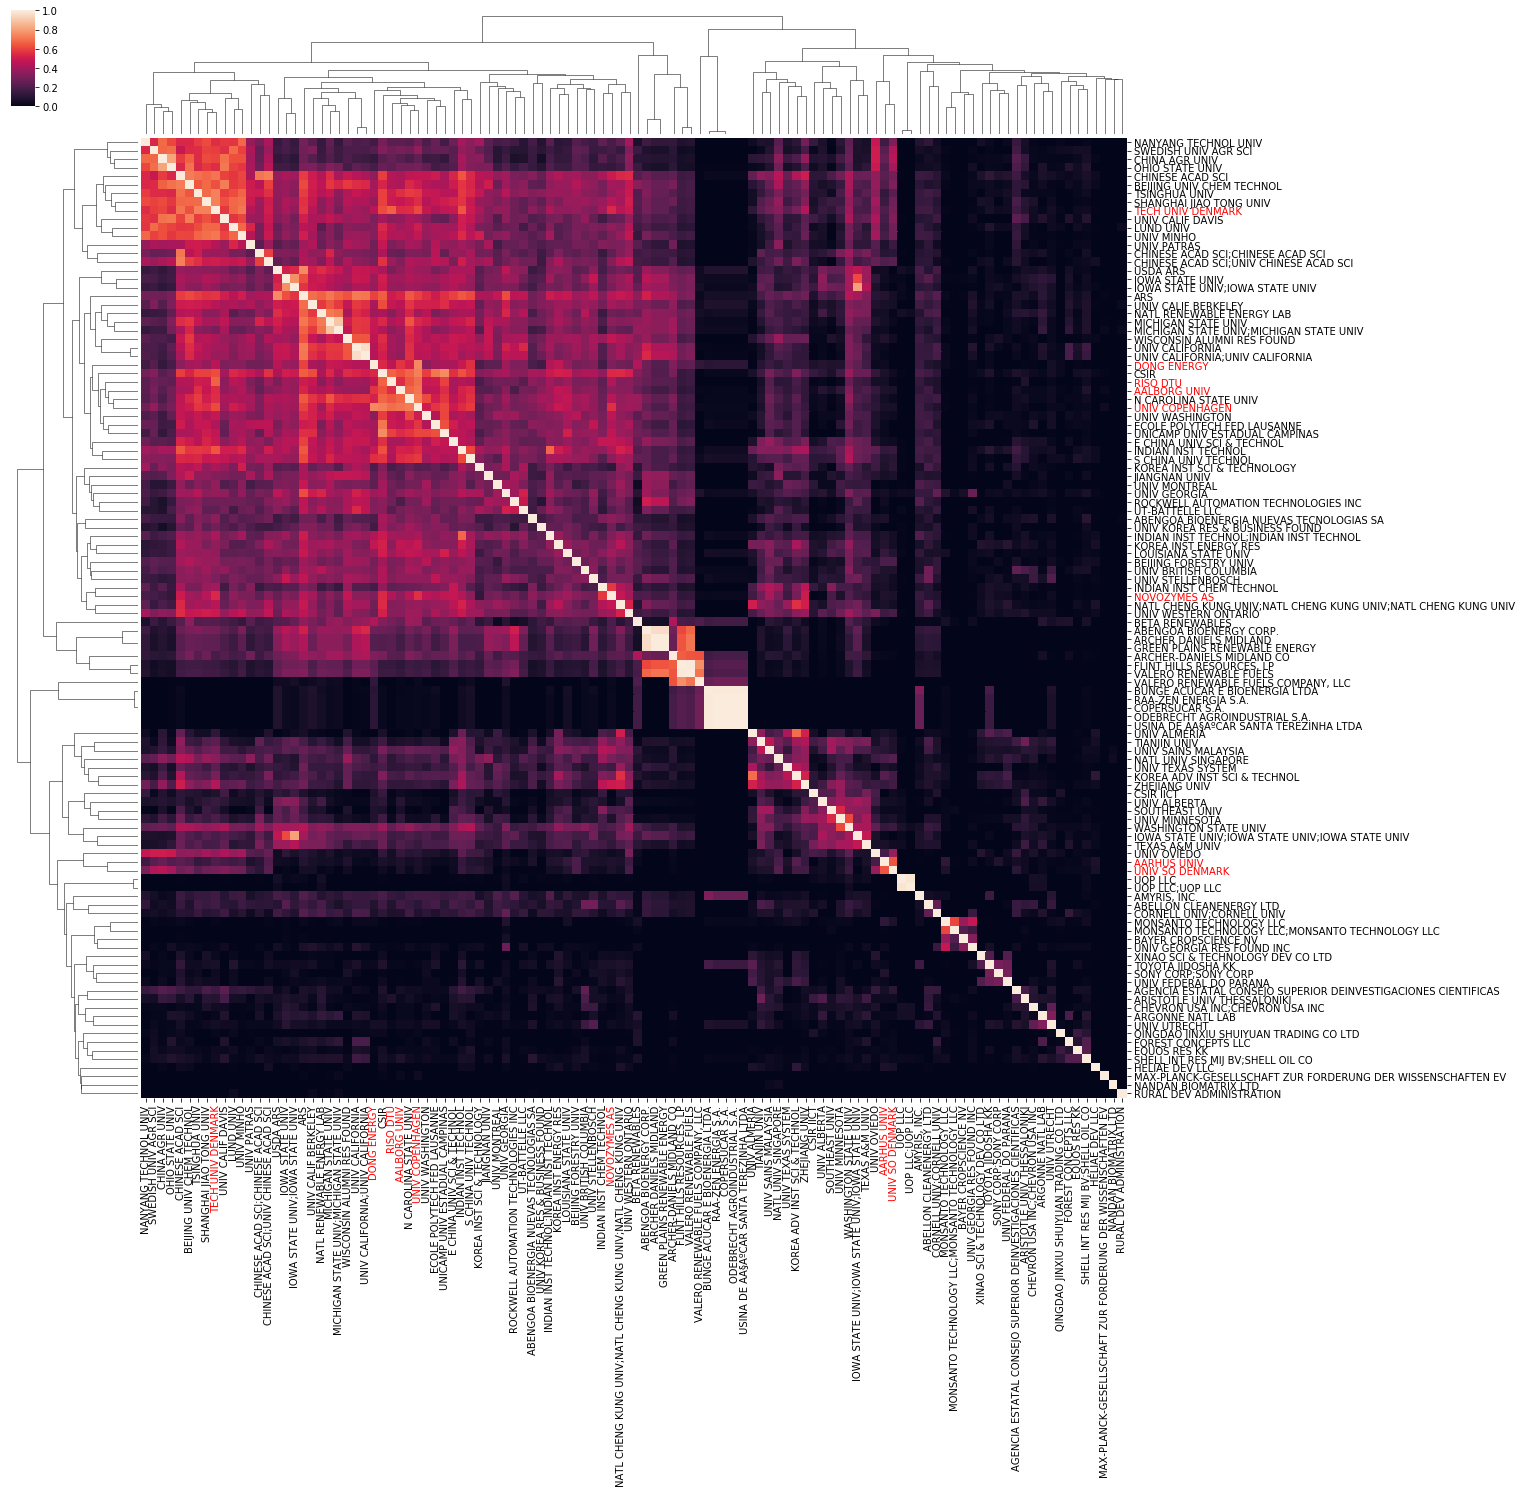

In [19]:
# plot the clustermap
g = sns.clustermap(org_correlation,  figsize=(20, 20), xticklabels = org_names, yticklabels=org_names)
teste = list(g.dendrogram_col.reordered_ind)

for tick_label in g.ax_heatmap.axes.get_yticklabels():
    tick_label.set_color(my_label_colors[tick_label.get_text()])
for tick_label in g.ax_heatmap.axes.get_xticklabels():
    tick_label.set_color(my_label_colors[tick_label.get_text()])

plt.show()

### 2.2.Organization profiles <a class="anchor" id="two-two"></a>

We select some organizations:

In [20]:
foc_org = ['TECH UNIV DENMARK', 'TSINGHUA UNIV', 'NOVOZYMES AS', 'UNIV CALIF BERKELEY']

And plot their profiles: 

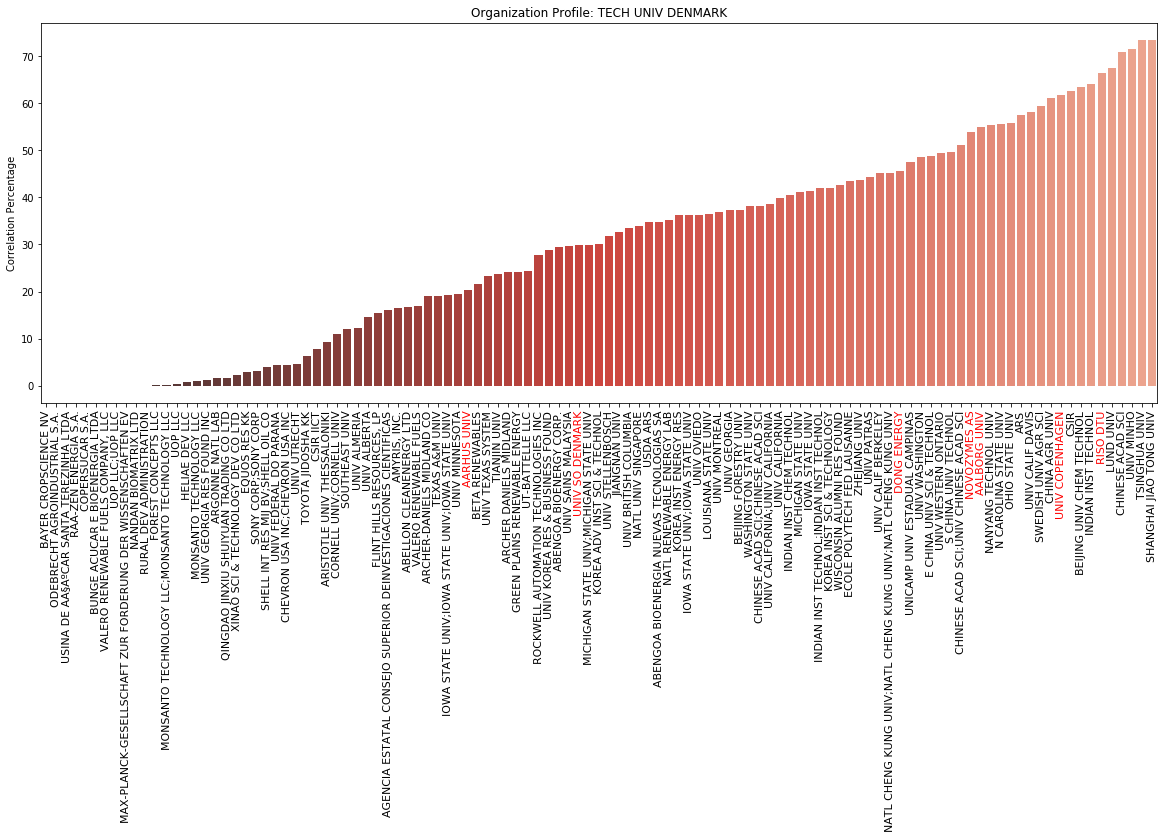

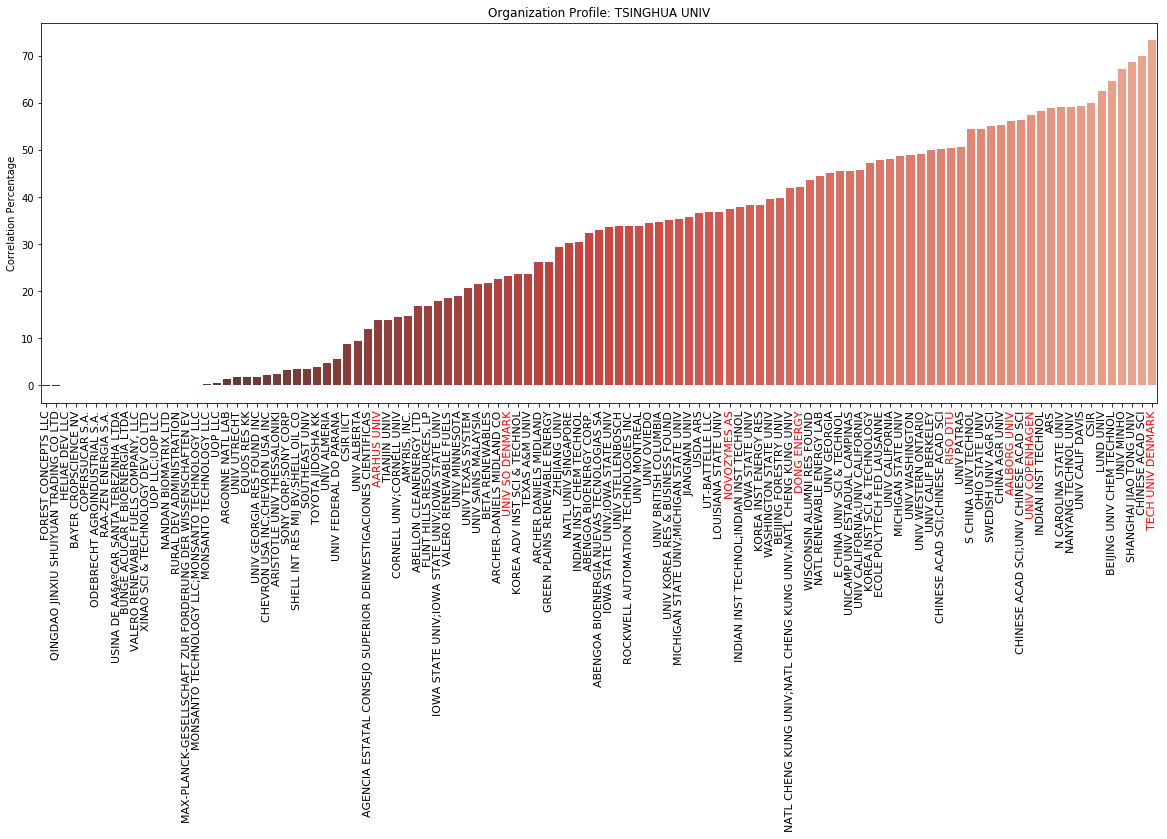

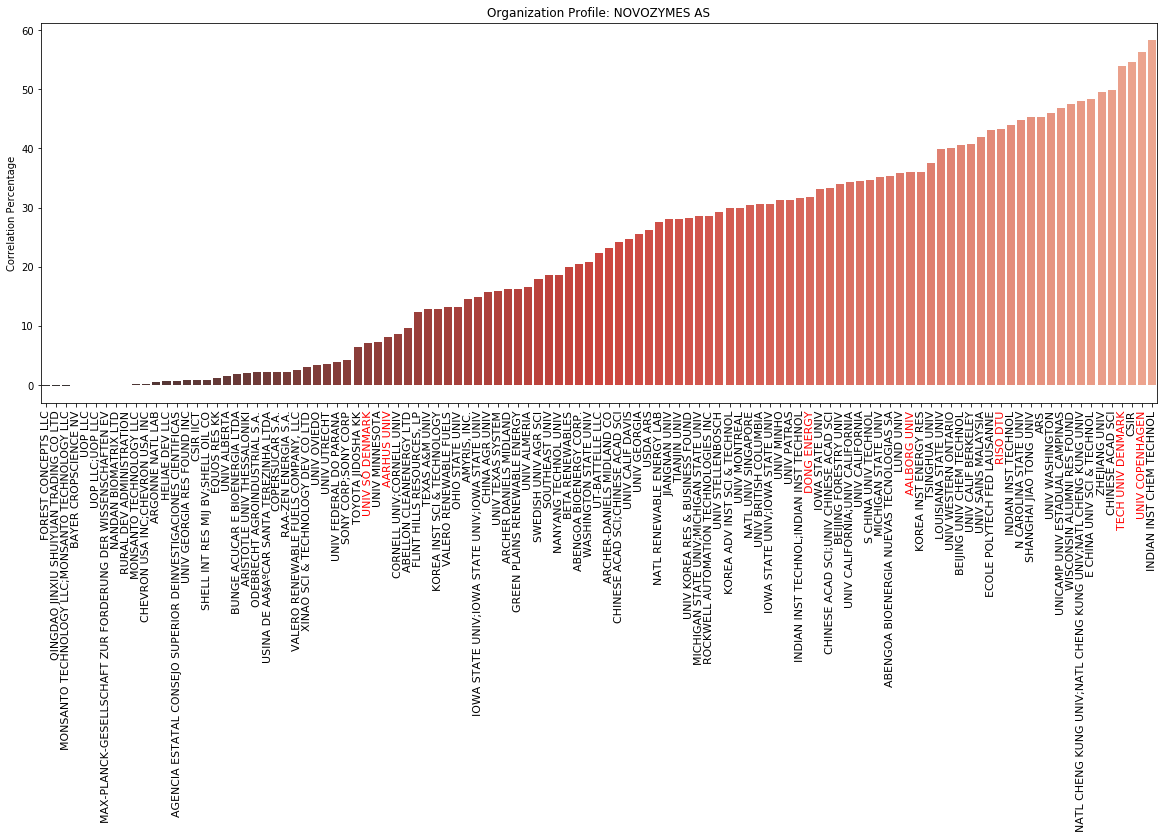

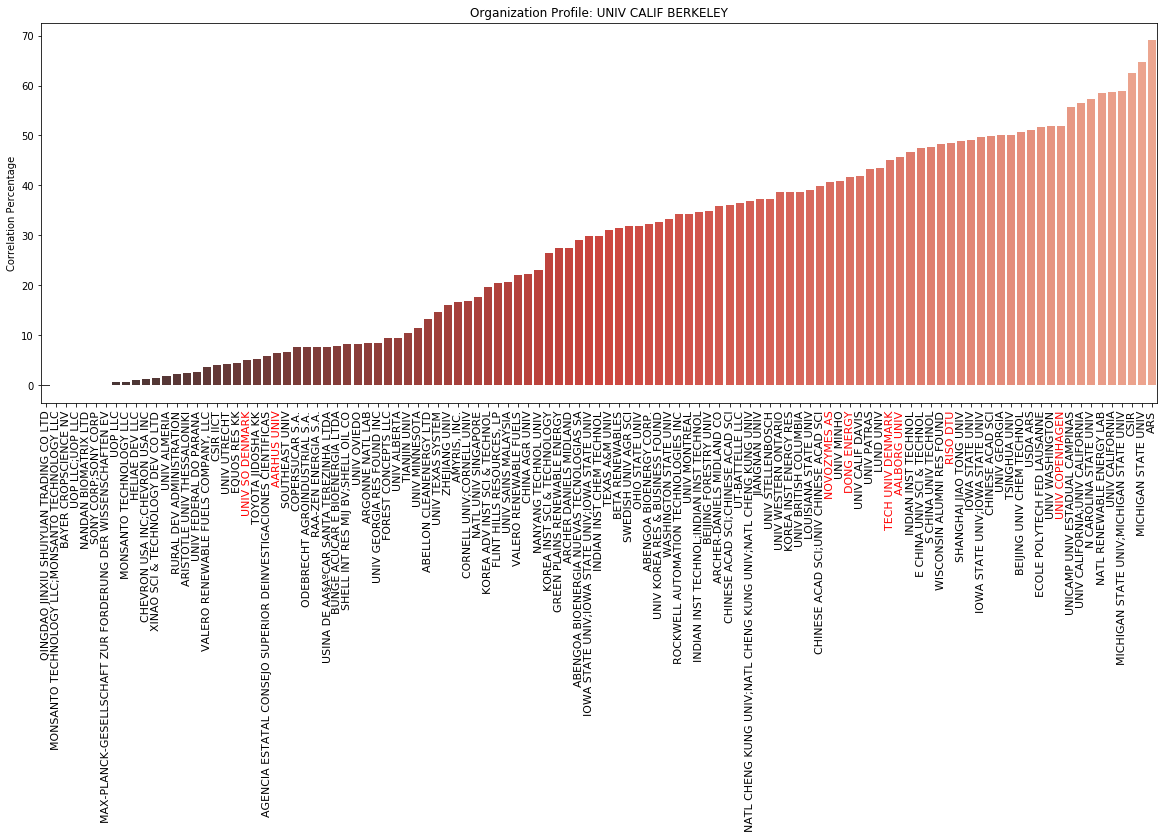

In [21]:
# for each country selected
for org in foc_org:
    
    # find the matrix slice
    org_index = find_index(org, org_names)
    histogram_data = org_correlation[:, org_index]
    
    # remove the country itself from data and labels
    histogram_data = np.delete(histogram_data, org_index)
    clean_org_names = np.delete(org_names, org_index)
    

    # sort labels and data
    sorted_names = [name for _,name in sorted(zip(histogram_data, clean_org_names))]
    histogram_data.sort()
    
    #plot
    plt.subplots(1,1,figsize=(20,7))
    sns.barplot(np.arange(len(histogram_data)), histogram_data * 100, palette="Reds_d")
    plt.xticks(np.arange(len(histogram_data)), sorted_names, rotation=90, fontsize=11)
    plt.title('Organization Profile: {}'.format(org))
    plt.ylabel('Correlation Percentage')
    
    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(my_label_colors[lbl.get_text()])
    
    
    plt.show()

## 3.Comparing organizations <a class="anchor" id="three"></a>

### 3.1.Visual Representation <a class="anchor" id="three-one"></a>

We select two organizations to compare: DTU and Tsinghua

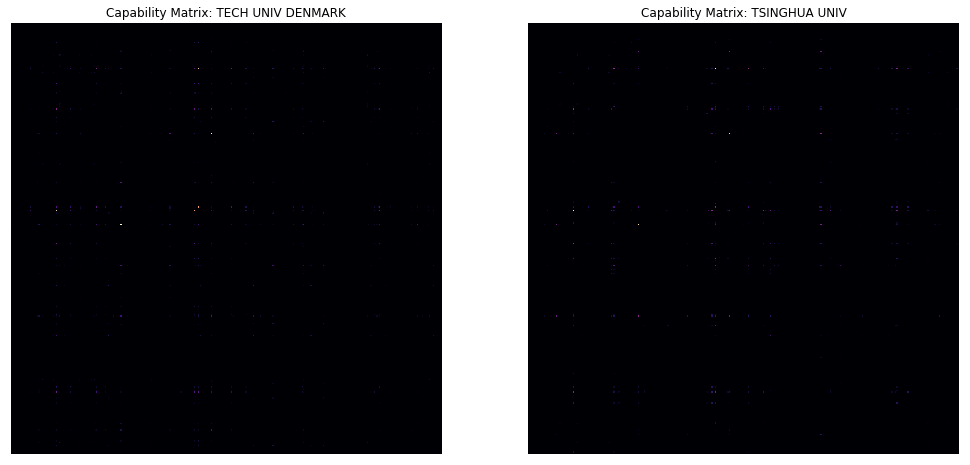

In [22]:
# call functions
dtu = 'TECH UNIV DENMARK'
compare_with = 'TSINGHUA UNIV'
colors = 'magma'
dtu_matrix = get_org_matrix(dtu, normalization=False)
scnd_matrix = get_org_matrix(compare_with, normalization=False)

# create a subplot
plt.subplots(2,1,figsize=(17,17))

# first heatmap
plt.subplot(121)
sns.heatmap(dtu_matrix, cmap=colors,  cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Capability Matrix: {}'.format(dtu))

# second heatmap
plt.subplot(122)
sns.heatmap(scnd_matrix, cmap=colors, cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Capability Matrix: {}'.format(compare_with))
plt.show()

We print a matrix of differences: 

In [23]:
cap_diff = np.absolute(dtu_matrix - scnd_matrix)

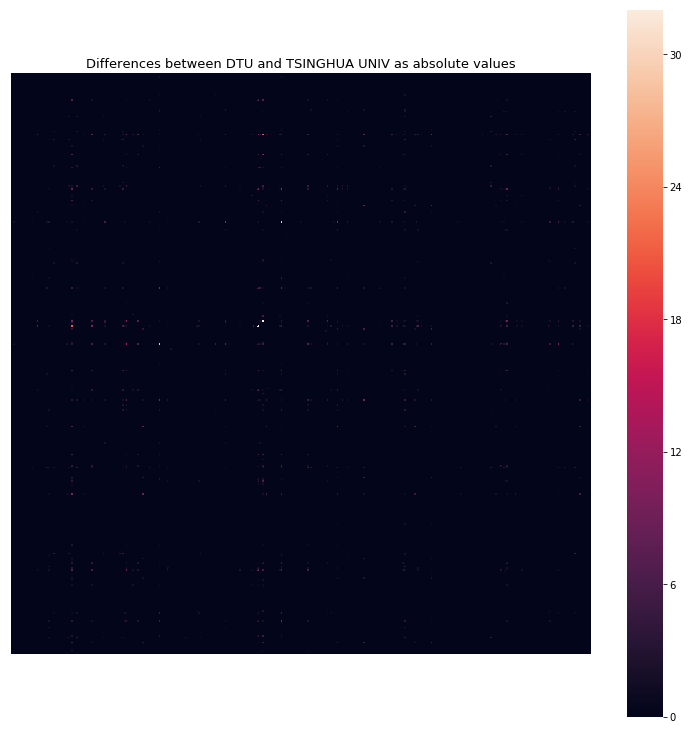

In [24]:
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(cap_diff, square=True, yticklabels=False, xticklabels=False)
plt.title('Differences between DTU and {} as absolute values'.format(compare_with), size=13)
plt.show()

### 3.2.Most frequent term pairs <a class="anchor" id="three-two"></a>

We create a function that given an organization, returns its top hits. 

In [25]:
def get_top_hits(orgMatrix, name):
    """
    The function prints the top occurences if fed a matrix of occurences, it also prints other types of valuable info.
    WARNING: Percentages are shown as 0 to 1. 
    """
        
    # list where all the values and indexes of matrix are stored
    top = 10
    values = []
    indexes = []
    no_duplicates = np.triu(orgMatrix, 1)
    total_documents = np.sum(no_duplicates)
    
    
    # loop through the matrix
    for row_n in range(dtu_matrix.shape[0]):
        for col_n in range(dtu_matrix.shape[1]):
            values.append(no_duplicates[row_n, col_n])
            indexes.append((row_n, col_n))
    
    
    # order the indexes and get the top
    Z = [indexes for _,indexes in sorted(zip(values,indexes))]
    extremes = Z[-top :]
    
    
    # create dataframe
    term_Dataframe = pd.DataFrame(
        {'First Term': [matrix_axis_names[e[0]] for e in extremes],
         'Second Term': [matrix_axis_names[e[1]] for e in extremes],
         'Number of Documents': [int(no_duplicates[e[0], e[1]]) for e in extremes], 
         'Percentage' : [no_duplicates[e[0], e[1]] / float(total_documents) for e in extremes], 
        })
    
    # prepare dataframe
    term_Dataframe = term_Dataframe[['First Term', 'Second Term','Number of Documents', 'Percentage']]
    term_Dataframe = term_Dataframe.sort_values('Number of Documents', ascending=False)
    
    
    # print everything
    print 'The top hits for the {} matrix: '.format(name)
    display(HTML(term_Dataframe.to_html(index=False)))
    
    
    print 'The total number of documents is {}.'.format(int(total_documents))
    print 'Note: Percentages are as 0-1 in this table. '

We apply it to DTU: 

In [26]:
get_top_hits(dtu_matrix, dtu)

The top hits for the TECH UNIV DENMARK matrix: 


First Term,Second Term,Number of Documents,Percentage
anaerobic digestion,biogas,53,0.035811
ethanol,fermentation,47,0.031757
bioethanol,fermentation,42,0.028378
ethanol,hydrolysis,20,0.013514
ethanol,enzymatic hydrolysis,17,0.011486
ethanol,cellulose,17,0.011486
hydrolysis,bioethanol,16,0.010811
fermentation,cellulose,15,0.010135
anaerobic digestion,algae,14,0.009459
bioethanol,cellulose,14,0.009459


The total number of documents is 1480.
Note: Percentages are as 0-1 in this table. 


We apply it to Tsinghua University: 

In [27]:
get_top_hits(scnd_matrix, compare_with)

The top hits for the TSINGHUA UNIV matrix: 


First Term,Second Term,Number of Documents,Percentage
ethanol,fermentation,26,0.042623
anaerobic digestion,biogas,24,0.039344
ethanol,hydrolysis,11,0.018033
ethanol,enzymatic hydrolysis,11,0.018033
ethanol,cellulose,10,0.016393
anaerobic digestion,waste,10,0.016393
bioethanol,fermentation,10,0.016393
fermentation,sugar,10,0.016393
fermentation,cellulose,9,0.014754
biogas,waste,9,0.014754


The total number of documents is 610.
Note: Percentages are as 0-1 in this table. 


### 3.3.Top differences <a class="anchor" id="three-three"></a>

Let us look at the top differences between these matrixes:

In [28]:
# list where all the values and indexes of matrix are stored
dtu_perc = dtu_matrix / np.sum(np.triu(dtu_matrix, 1)) * 100 # half only  
other_perc = scnd_matrix / np.sum(np.triu(scnd_matrix, 1)) * 100
differences = dtu_perc - other_perc
differences = np.absolute(differences)

values = []
indexes = []
no_duplicates = np.triu(differences, 1)

top = 20

# loop through the matrix
for row_n in range(differences.shape[0]):
    for col_n in range(differences.shape[1]):
        values.append(no_duplicates[row_n, col_n])
        indexes.append((row_n, col_n))

# print the table 
Z = [indexes for _,indexes in sorted(zip(values,indexes))]
extremes = list(reversed(Z[-top:]))


term_Dataframe = pd.DataFrame(
    {'First Term': [matrix_axis_names[e[0]] for e in extremes],
     'Second Term': [matrix_axis_names[e[1]] for e in extremes],
     'DTU Percentage': [dtu_perc[e[0], e[1]] for e in extremes], 
     '{} Percentage'.format(compare_with): [other_perc[e[0], e[1]] for e in extremes], 
     'Difference in %': [no_duplicates[e[0], e[1]] for e in extremes]
    })

term_Dataframe = term_Dataframe[['First Term', 'Second Term', 'DTU Percentage', '{} Percentage'.format(compare_with), 'Difference in %']]


display(HTML(term_Dataframe.to_html(index=False)))
print 'Percentages are as 0-100 in this table for easy viz.'

First Term,Second Term,DTU Percentage,TSINGHUA UNIV Percentage,Difference in %
bioethanol,fermentation,2.837838,1.639344,1.198494
fermentation,sorghum,0.000000,1.147541,1.147541
hydrolysis,biodiesel,0.000000,1.147541,1.147541
ethanol,fermentation,3.175676,4.262295,1.086619
fermentation,sugar,0.608108,1.639344,1.031236
biopolymers,fermentation,0.000000,0.983607,0.983607
gasoline,fermentation,0.000000,0.983607,0.983607
sewage,anaerobic digestion,0.337838,1.311475,0.973638
anaerobic digestion,algae,0.945946,0.000000,0.945946
sewage,waste,0.405405,1.311475,0.906070


Percentages are as 0-100 in this table for easy viz.


## 4.Collaborations <a class="anchor" id="four"></a>
### 4.1.All organizations <a class="anchor" id="four-one"></a>

A helper function to categorize collaborations: 

In [29]:
def collaboration_inspector(org_):
    
    """
    This function returns the total amount of university and non university collaborations. 
    This is done by detection of the UNIV term.
    RETURNS: dictionnary of data
    """
    
    # query
    collab_query = """
                    MATCH (a:Asset)
                    WHERE a.owner CONTAINS "{}"
                    RETURN a.owner, count(a)
                    ORDER BY count(a) desc""".format(org_)
    
    # convert to dataframe and extract total docs 
    DATA = DataFrame(connection_to_graph.data(collab_query))
    total_docs = DATA['count(a)'].sum()
    
    # replace own name to avoid detection
    DATA = DATA.replace({'{}'.format(org_): 'None'}, regex=True)
    
    # loop through rows in search of term and count
    university_partnerships_counter = 0
    other_partnerships_counter = 0
    for index, row in DATA.iterrows():
        collaborators = row['a.owner']
        documents = row['count(a)']
        if 'UNIV' in collaborators:
            university_partnerships_counter = university_partnerships_counter + documents
        else:
            other_partnerships_counter = other_partnerships_counter + documents
    
    # build data structure and return
    data = {
        'total_documents': int(total_docs), 
        'univ_partnerships': university_partnerships_counter,
        'univ_partnerships_perc': university_partnerships_counter /float(total_docs) * 100.0,
        'other_partnerships': other_partnerships_counter,
        'other_partnerships_perc': other_partnerships_counter /float(total_docs) * 100.0
        }
    
    return data

We use the function in all organizations: 

In [30]:
names = []
univ_perc = []
other_perc = []

for org in org_names:
    names.append(org)
    dict_ = collaboration_inspector(org.encode('utf-8'))
    univ_perc.append(dict_['univ_partnerships_perc'])
    other_perc.append(dict_['other_partnerships_perc'])

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/pandas/core/internals.py:4608: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



And we plot the results: 

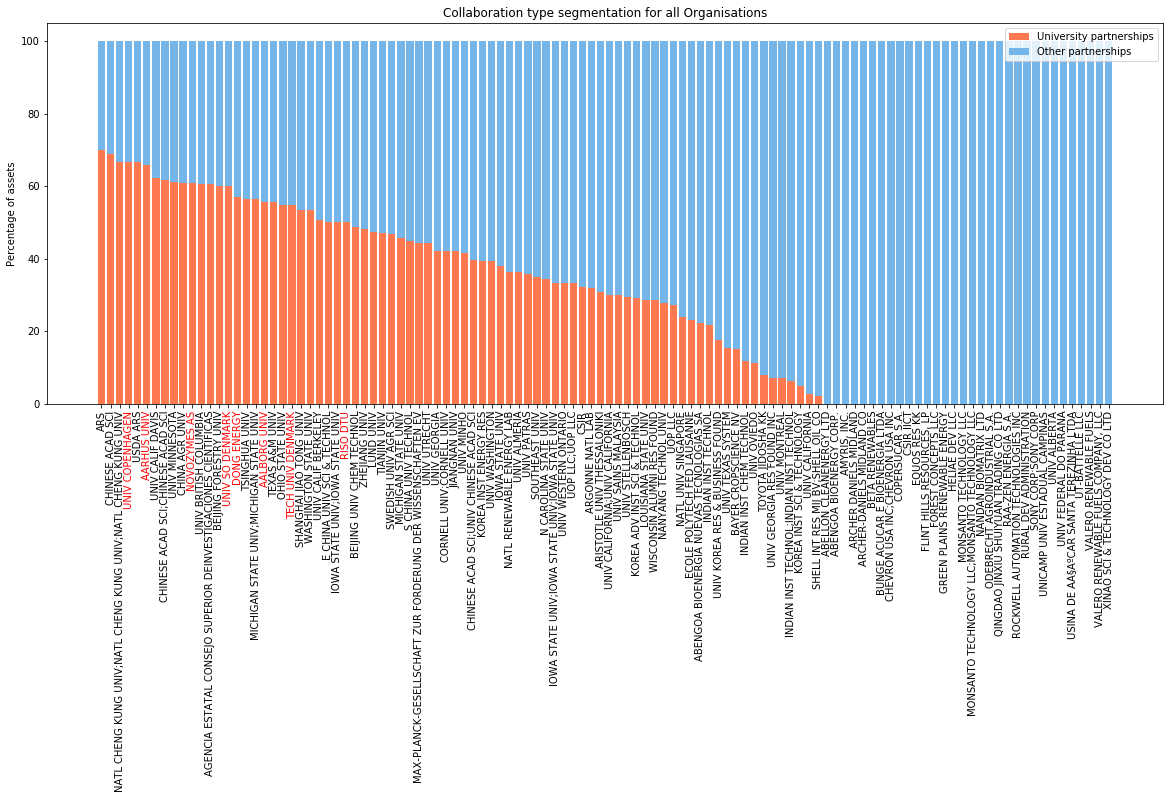

In [31]:
ordered_names = [x for _,x in sorted(zip(other_perc,names))]
univ_per_ordered = [univ_perc[names.index(word)] for word in ordered_names]
other_per_ordered = [other_perc[names.index(word)] for word in ordered_names]


plt.subplots(1,1,figsize=(20,7))
plt.bar(range(len(univ_per_ordered)), univ_per_ordered, color='#ff7950', label='University partnerships')
plt.bar(range(len(univ_per_ordered)), other_per_ordered, bottom=univ_per_ordered, color='#74b5ea', label='Other partnerships')
plt.xticks(range(len(univ_per_ordered)), ordered_names, rotation='vertical')
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(my_label_colors[lbl.get_text()])
plt.title('Collaboration type segmentation for all Organisations')
plt.ylabel('Percentage of assets')
plt.legend()
plt.show()

ARS is the [Agricultural Research Service](https://www.ars.usda.gov/)

### 4.2.Universities <a class="anchor" id="four-two"></a>

We limit the graph to universities: 

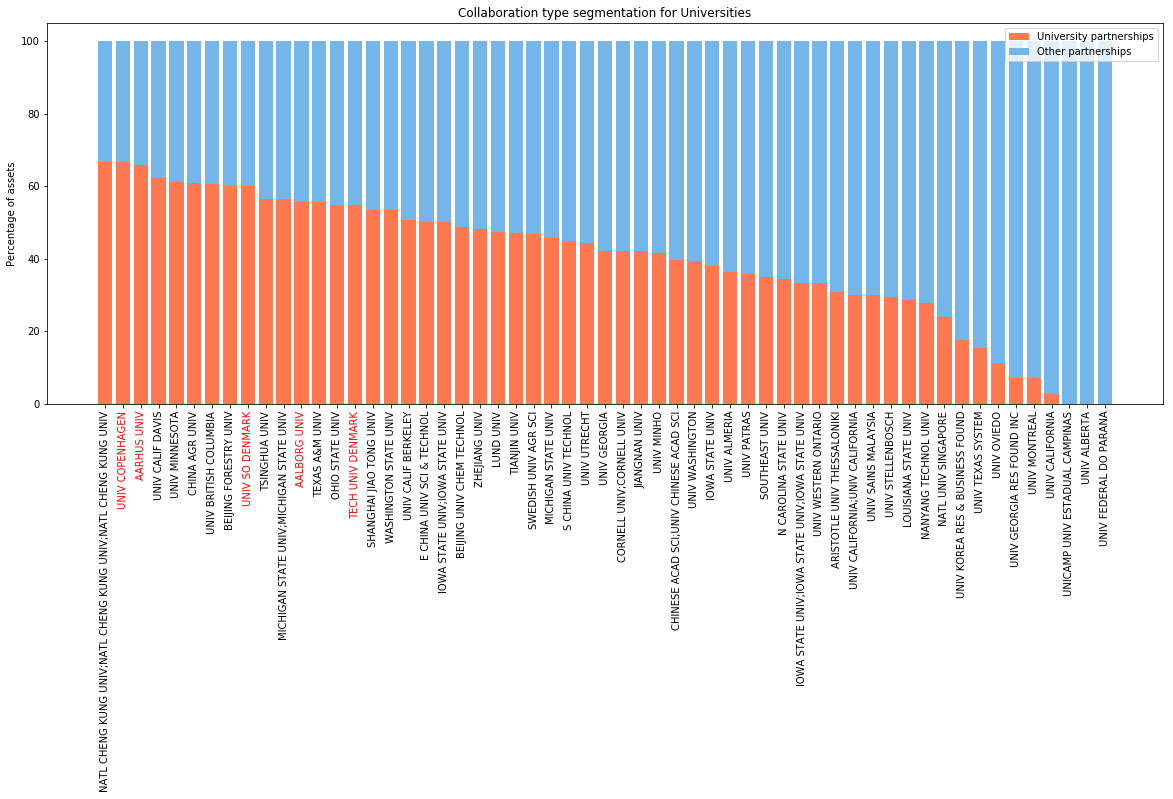

In [32]:
names = []
univ_perc = []
other_perc = []

for org in org_names:
    if 'UNIV' in org:
        names.append(org)
        dict_ = collaboration_inspector(org.encode('utf-8'))
        univ_perc.append(dict_['univ_partnerships_perc'])
        other_perc.append(dict_['other_partnerships_perc'])
    
ordered_names = [x for _,x in sorted(zip(other_perc,names))]
univ_per_ordered = [univ_perc[names.index(word)] for word in ordered_names]
other_per_ordered = [other_perc[names.index(word)] for word in ordered_names]


plt.subplots(1,1,figsize=(20,7))
plt.bar(range(len(univ_per_ordered)), univ_per_ordered, color='#ff7950', label='University partnerships')
plt.bar(range(len(univ_per_ordered)), other_per_ordered, bottom=univ_per_ordered, color='#74b5ea', label='Other partnerships')
plt.xticks(range(len(univ_per_ordered)), ordered_names, rotation='vertical')
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(my_label_colors[lbl.get_text()])
plt.title('Collaboration type segmentation for Universities')
plt.ylabel('Percentage of assets')
plt.legend()
plt.show()

### 4.3.Non-Universities <a class="anchor" id="four-three"></a>

We limit the graph to non-universities: 

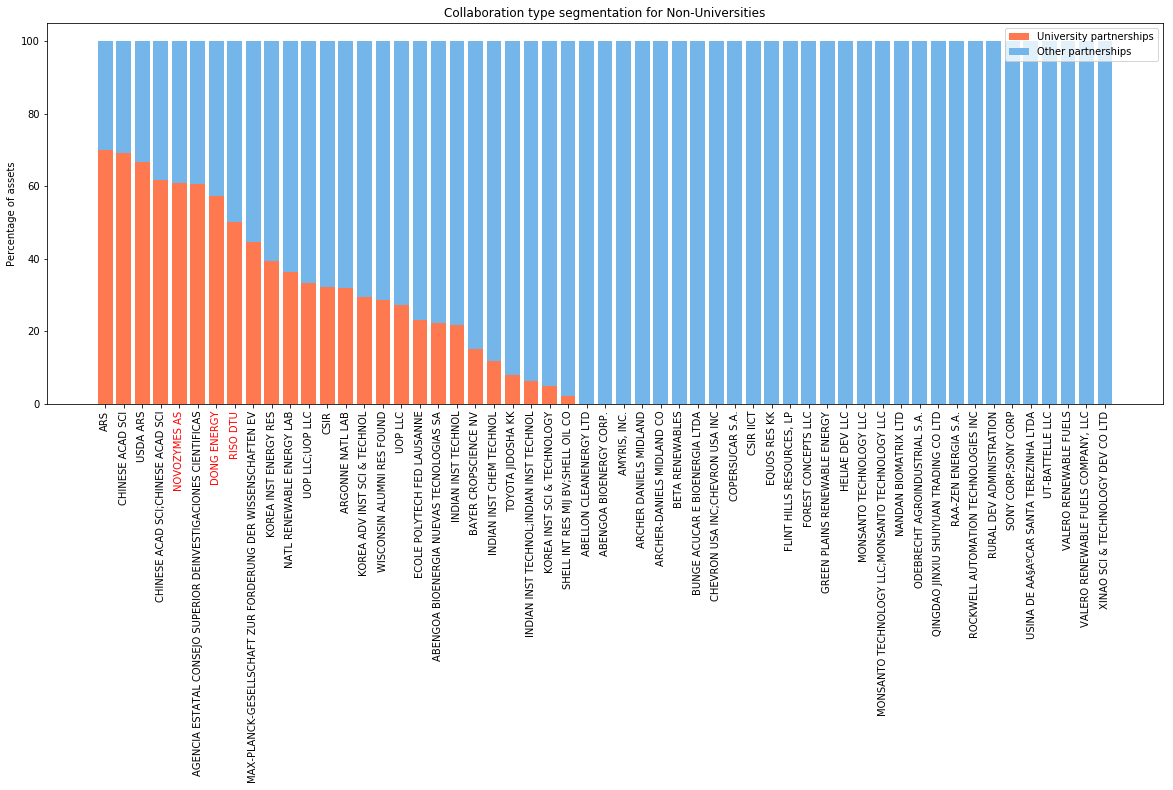

In [33]:
names = []
univ_perc = []
other_perc = []

for org in org_names:
    if 'UNIV' not in org:
        names.append(org)
        dict_ = collaboration_inspector(org.encode('utf-8'))
        univ_perc.append(dict_['univ_partnerships_perc'])
        other_perc.append(dict_['other_partnerships_perc'])
    
ordered_names = [x for _,x in sorted(zip(other_perc,names))]
univ_per_ordered = [univ_perc[names.index(word)] for word in ordered_names]
other_per_ordered = [other_perc[names.index(word)] for word in ordered_names]


plt.subplots(1,1,figsize=(20,7))
plt.bar(range(len(univ_per_ordered)), univ_per_ordered, color='#ff7950', label='University partnerships')
plt.bar(range(len(univ_per_ordered)), other_per_ordered, bottom=univ_per_ordered, color='#74b5ea', label='Other partnerships')
plt.xticks(range(len(univ_per_ordered)), ordered_names, rotation='vertical')
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(my_label_colors[lbl.get_text()])
plt.title('Collaboration type segmentation for Non-Universities')
plt.ylabel('Percentage of assets')
plt.legend()
plt.show()

## 5.Organizational spectrums <a class="anchor" id="five"></a>

### 5.1.Zoom in version <a class="anchor" id="five-one"></a>

Let us limit organizations and term pairs to proove the concept. 

In [34]:
def get_org_values(org_):
    """
    Returns the organization DNA, if 'root' then it returns all of the names of the term pairs. 
    """

    matrix = get_org_matrix(org_, normalization=False)
    matrix_tri = np.triu(matrix, 1)
    
    values = []
    indexes = []
    
    
    # loop through the matrix
    for row_n in range(matrix_tri.shape[0]):
        for col_n in range(matrix_tri.shape[1]):
            values.append(matrix_tri[row_n, col_n])
            indexes.append((row_n, col_n))
            
    if org_ == 'root':
        term_tuples = ['{}/{}'.format(matrix_axis_names[a[0]], matrix_axis_names[a[1]]) for a in indexes]
        return term_tuples
    else: 
        return values

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning:

invalid value encountered in divide



The original shape was of 4 organizations and 123904 term pairs.
99% of the term pairs were empty.
The final shape is of 4 organizations and 726 term pairs.
Here, reduced to 45 for visualization purposes.


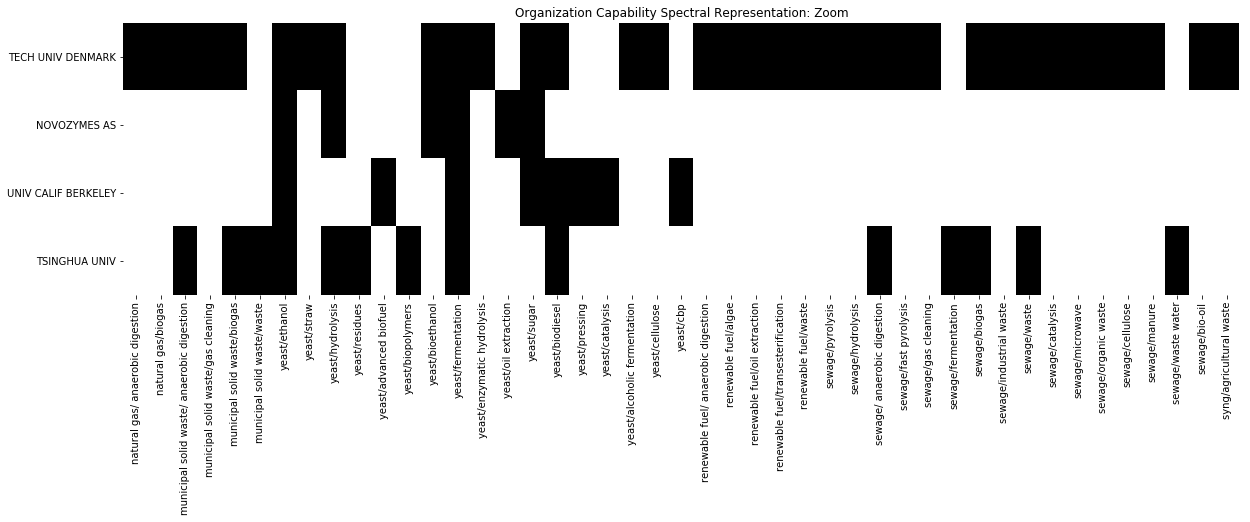

In [35]:
# define countries
scope_organizations = ['TECH UNIV DENMARK', 'NOVOZYMES AS', 'UNIV CALIF BERKELEY', 'TSINGHUA UNIV']

# create heatmap and names of capability terms array
scope_matrix = np.zeros((len(scope_organizations), len(get_org_values('TECH UNIV DENMARK'))))
capability_pair_names = np.asarray(get_org_values('root'))

# build the matrix
for i in range(len(scope_organizations)):
    scope_matrix[i, :] = get_org_values(scope_organizations[i])

# detect if a certain term pair is not used at all by computing the column sum
column_sum = np.sum(scope_matrix, axis=0)
zero_counter = 0
zero_indexes_array = []
for i in range(len(column_sum)):
    if column_sum[i] == 0.0:
        zero_counter += 1
        zero_indexes_array.append(i)

# delete the empty term pairs
print 'The original shape was of {} organizations and {} term pairs.'.format(scope_matrix.shape[0], scope_matrix.shape[1])
print '{}% of the term pairs were empty.'.format(zero_counter * 100 / len(column_sum))
scope_matrix = np.delete(scope_matrix, zero_indexes_array, 1) 
capability_pair_names = np.delete(capability_pair_names, zero_indexes_array)
print 'The final shape is of {} organizations and {} term pairs.'.format(scope_matrix.shape[0], scope_matrix.shape[1])


# limit the visualization
limit = 45
print 'Here, reduced to {} for visualization purposes.'.format(limit)

plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(scope_matrix[:, 0:limit],cmap=ListedColormap(['white', 'black']), center=0.01, cbar=None, square=False, yticklabels=scope_organizations, xticklabels=capability_pair_names[0:limit])
plt.title('Organization Capability Spectral Representation: Zoom')
plt.show()

### 5.2.Limited Organizations <a class="anchor" id="five-two"></a>

We extend it but limit the organizations: 

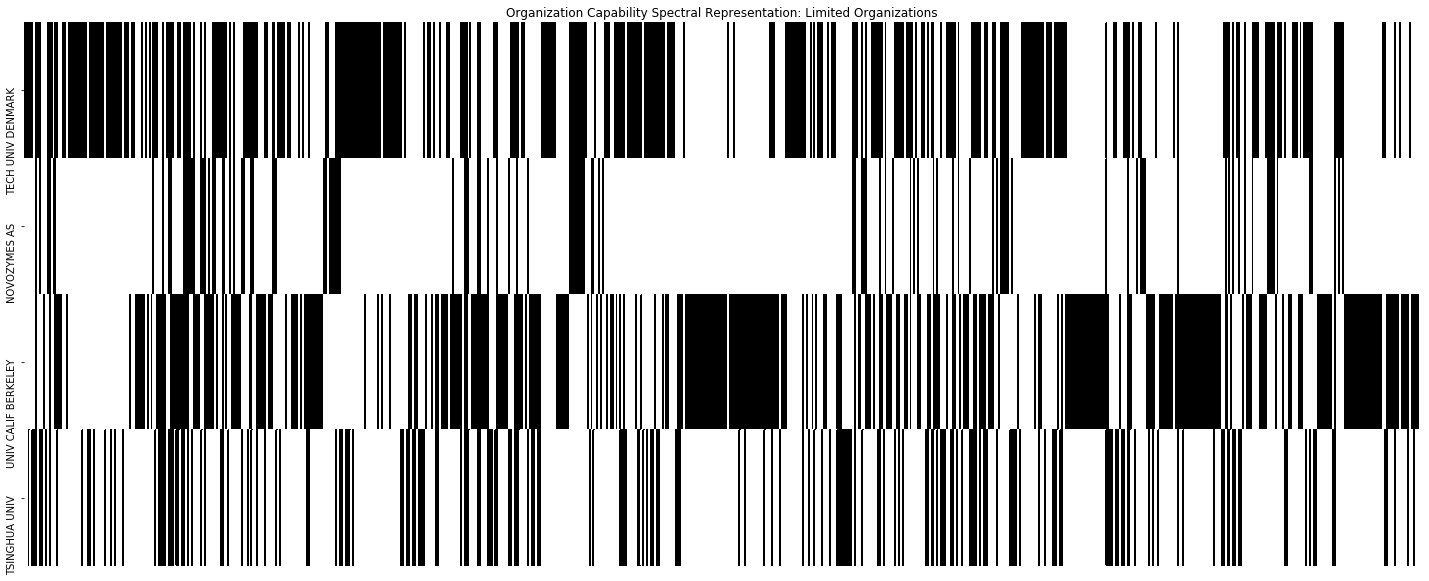

In [36]:
plt.subplots(1,1,figsize=(25, 10))
plt.subplot(111)
sns.heatmap(scope_matrix,cmap=ListedColormap(['white', 'black']), center=0.01, cbar=None, square=False, yticklabels=scope_organizations, xticklabels=False)
plt.title('Organization Capability Spectral Representation: Limited Organizations')
plt.show()

### 5.3.Full representation <a class="anchor" id="five-three"></a>

We plot all the organizations and term pairs

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning:

invalid value encountered in divide



The original shape was of 112 organizations and 123904 term pairs.
96% was empty.
The original shape was of 112 organizations and 3844 term pairs.


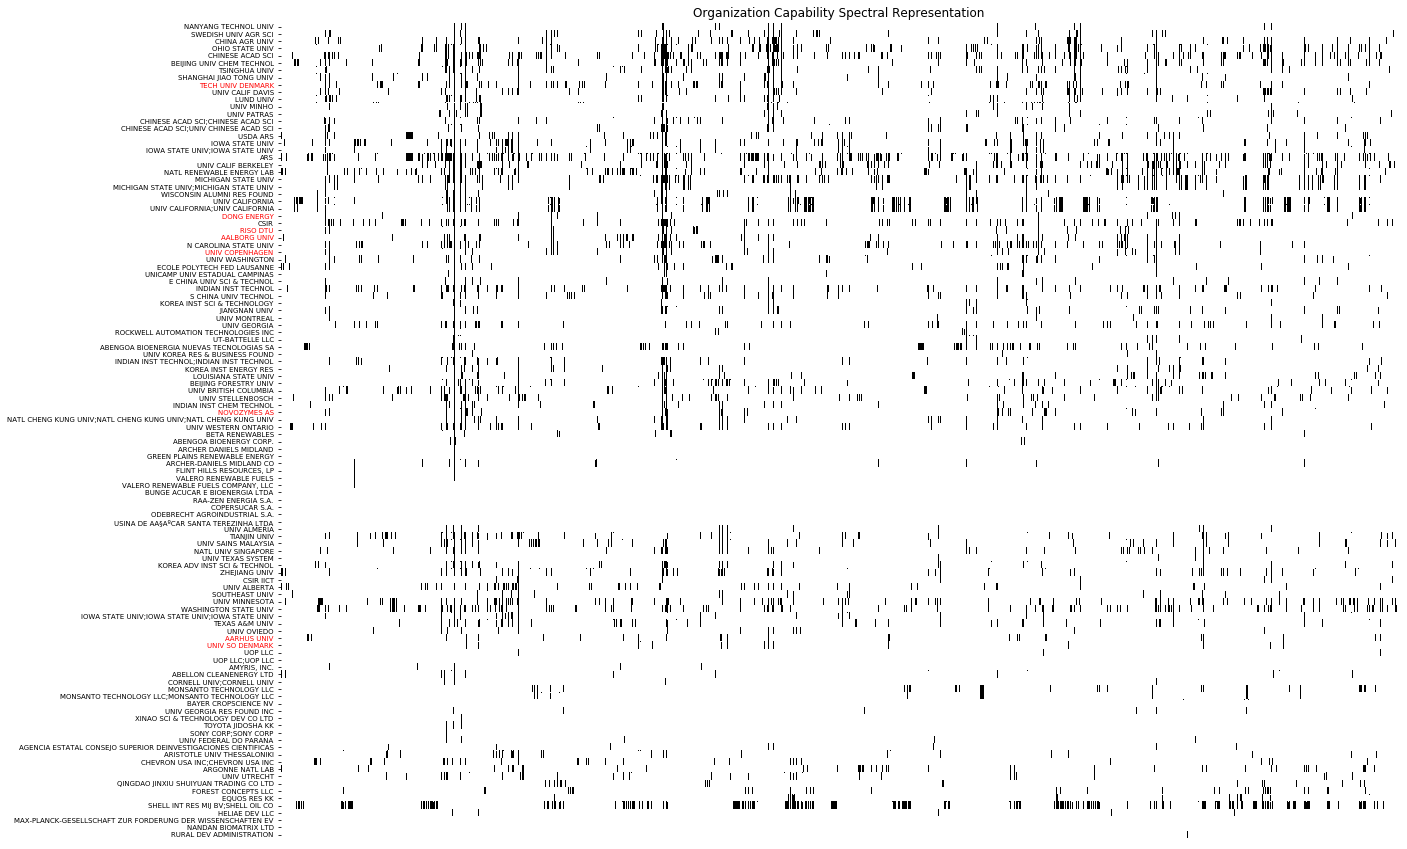

In [37]:
# prepare heatmap

org_names = [org_names[i] for i in list(np.load('Data/cluster_org_order.npy'))]

jumbo_matrix = np.zeros((len(org_names), len(get_org_values('Denmark'))))

# build heatmap                 
for i in range(len(org_names)):
    jumbo_matrix[i, :] = get_org_values(org_names[i].encode('utf-8'))
                        
# delete 0 entries
column_sum = np.sum(jumbo_matrix, axis=0)
zero_counter = 0
zero_indexes_array = []
for i in range(len(column_sum)):
    if column_sum[i] == 0.0:
        zero_counter += 1
        zero_indexes_array.append(i)

# adjust size to empy cells and output info
print 'The original shape was of {} organizations and {} term pairs.'.format(jumbo_matrix.shape[0], jumbo_matrix.shape[1])
print '{}% was empty.'.format(zero_counter * 100 / len(column_sum))
jumbo_matrix = np.delete(jumbo_matrix, zero_indexes_array, 1) 
print 'The original shape was of {} organizations and {} term pairs.'.format(jumbo_matrix.shape[0], jumbo_matrix.shape[1])

plt.subplots(1,1,figsize=(20, 15))
plt.subplot(111)
sns.heatmap(jumbo_matrix,cmap=ListedColormap(['white', 'black']), center=0.01, cbar=None, square=False, yticklabels=org_names, xticklabels=False)
plt.yticks(rotation=0, size=7)
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(my_label_colors[lbl.get_text()])
plt.title('Organization Capability Spectral Representation')
plt.show()

### 5.4.DTU neighbours <a class="anchor" id="five-four"></a>

Only the organizations that are more related to DTU. 

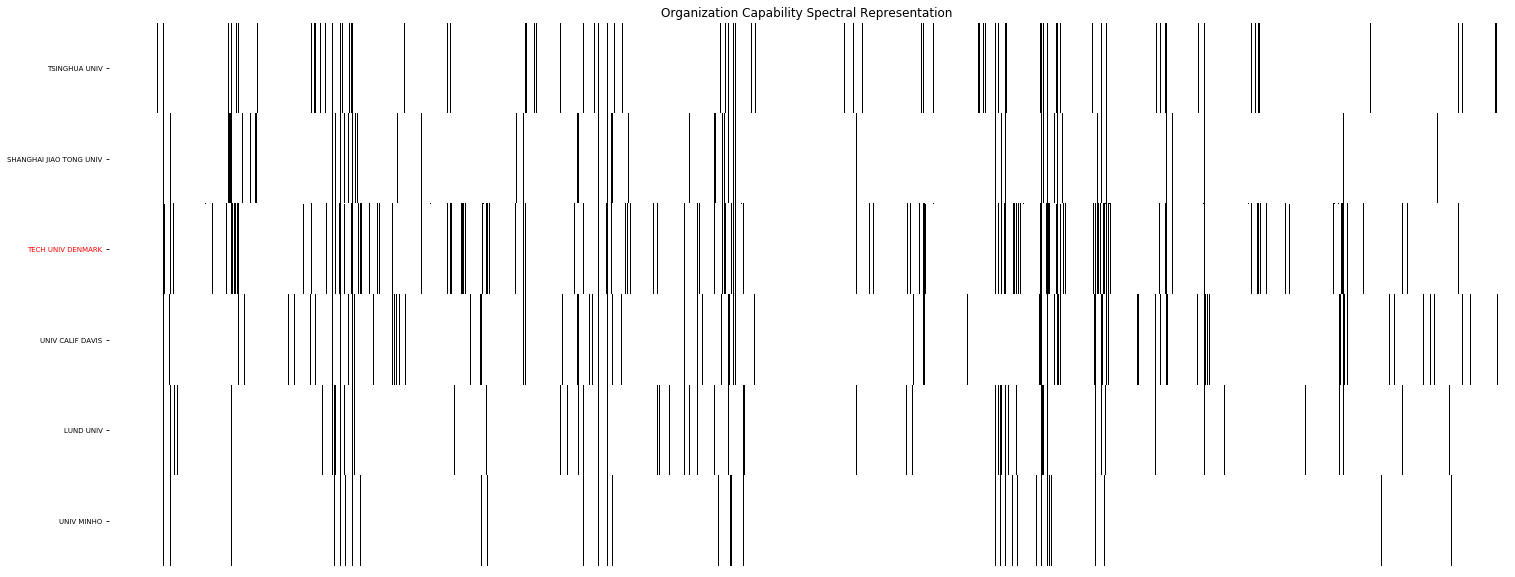

In [38]:
plt.subplots(1,1,figsize=(25, 10))
plt.subplot(111)
sns.heatmap(jumbo_matrix[6:12, :],cmap=ListedColormap(['white', 'black']), center=0.01, cbar=None, square=False, yticklabels=org_names[6:12], xticklabels=False)
plt.yticks(rotation=0, size=7)
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(my_label_colors[lbl.get_text()])
plt.title('Organization Capability Spectral Representation')
plt.show()